
# Web Server Log Analysis
 
##### This example demonstrates parsing (including incorrectly formated strings) and analysis of web server log data . 

The lines may look like

* local - - [24/Oct/1994:13:41:41 -0600] "GET index.html HTTP/1.0" 200 150
* remote - - [27/Oct/1994:23:17:17 -0600] "GET index.html 200 3185
* local - - [27/Oct/1994:15:28:10 -0600] "GET index.html Inch Nails HTTP/1.0" 404 -


Out of 726739 log-lines, 723267 are parsed with protocol info, 1847 are parsed without protocol info, 1419 are of the "local index.html"-type and carry no useful information, and 206 lines are left unparsed till further decision.

##### The analysis includes:

1. Step-by-step parsing of log lines to arrive at final "production" parsing code

2. Exploratory data analysis and visualizations

3. Analysis of "notFound" (404) response codes and visualizations

The data are taken from [here](http://ita.ee.lbl.gov/html/contrib/Calgary-HTTP.html). The code assumes that the file "calgary_access_log.gz" is downloaded, gunziped and put into "data" subdirectory.

# 1. Parsing

We create "logFileRDD" of the file by reading it as a collection of lines. For a start we have a look at the first several lines

In [1]:
import os
logFile = os.path.join('data', 'calgary_access_log')
logFileRDD = sc.textFile(logFile, 4).cache()
logFileRDD.take(5)

[u'local - - [24/Oct/1994:13:41:41 -0600] "GET index.html HTTP/1.0" 200 150',
 u'local - - [24/Oct/1994:13:41:41 -0600] "GET 1.gif HTTP/1.0" 200 1210',
 u'local - - [24/Oct/1994:13:43:13 -0600] "GET index.html HTTP/1.0" 200 3185',
 u'local - - [24/Oct/1994:13:43:14 -0600] "GET 2.gif HTTP/1.0" 200 2555',
 u'local - - [24/Oct/1994:13:43:15 -0600] "GET 3.gif HTTP/1.0" 200 36403']

These lines comply to [Apache Common Log Format (CLF)](http://httpd.apache.org/docs/1.3/logs.html#common).
We briefly summarize the content of the fields

1. IP address of the client ("local" in the example above)

2. RFC 1413 identity of the client (The "hyphen" in the output indicates that the requested piece of information is not available)

3. userid of the person requesting the document

4. time that the server finished processing the request

5. method used by the client in the request line ("GET") 

6. resource requested by the client ("index.html" or various GIF files)

7. protocol used by the client (HTTP/1.0)

8. response code according to [HTTP Specification](http://www.w3.org/Protocols/rfc2616/rfc2616-sec10.html) that the server sends back to the client (200 means OK, the request has succeded)

9. the size of the content returned to the client

Let us parse each line of our RDD accordingly

In [2]:
# A regular expression pattern to extract fields from the log line
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+) (\S+)" (\d{3}) (\S+)'

In [3]:
# check correct pattern for datetime - we neglect the time zone shift for the moment
import datetime
stri = "24/Oct/1994:13:41:41 -0600"
dt = datetime.datetime.strptime(stri[:20], "%d/%b/%Y:%H:%M:%S")
print dt

1994-10-24 13:41:41


In [4]:
import re
from pyspark.sql import Row

def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Inputs:
        logline (str): a line of text in the Apache Common Log format
    Outputs:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(
        host          = match.group(1),
        client_id = match.group(2),
        user_id       = match.group(3),
        date_time     = datetime.datetime.strptime(match.group(4)[:20], "%d/%b/%Y:%H:%M:%S"), #parse_apache_time(match.group(4)),
        method        = match.group(5), #.toupper()
        request      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

We will keep track of correctly parsed and failed logs are returned those as two RDDs

In [5]:
def access_fail_logs(parsed_logs):
    """ Read and parse log file, print a 20-sample of failed log-lines
    Inputs:
        parsed_logs (RDD): an RDD obtained via parseApacheLogLine(...)
    Outputs:
        tuple of RDDs: access_logs, failed_logs
    """
    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print 'Number of invalid logline: %d' % failed_logs.count()
        for line in failed_logs.take(20):
            print 'Invalid logline: %s' % line

    print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsed_logs.count(), access_logs.count(), failed_logs.count())
    return access_logs, failed_logs

Now that our functions are ready let us start with parsing lines

In [6]:
parsedLogsRDD = logFileRDD.map(parseApacheLogLine).cache()
accessLogsRDD, failedLogsRDD = access_fail_logs(parsedLogsRDD)

Number of invalid logline: 4459
Invalid logline: local 780     index.html
Invalid logline: local      index.html
Invalid logline: remote - - [24/Oct/1994:17:18:19 -0600] "GET 155.gif" 200 2555
Invalid logline: remote - - [24/Oct/1994:17:18:55 -0600] "GET 156.gif" 200 36403
Invalid logline: remote - - [24/Oct/1994:17:19:02 -0600] "GET 157.gif" 200 441
Invalid logline: local      index.html
Invalid logline: remote - - [27/Oct/1994:12:42:44 -0600] "GET 576.html tp:// HTTP/1.0" 404 -
Invalid logline: local - - [27/Oct/1994:15:28:10 -0600] "GET index.html Inch Nails HTTP/1.0" 404 -
Invalid logline: local - - [27/Oct/1994:15:29:14 -0600] "GET index.html Inch Nails HTTP/1.0" 404 -
Invalid logline: remote - - [27/Oct/1994:18:51:50 -0600] "GET index.html 200 3185
Invalid logline: remote - - [27/Oct/1994:23:17:17 -0600] "GET index.html 200 3185
Invalid logline: local - - [28/Oct/1994:00:23:22 -0600] "GET 619.html" 404 -
Invalid logline: local - - [28/Oct/1994:00:24:32 -0600] "GET 620.html" 404 -

There are many lines that failed to parse. Some of them (like "local 780 index.html") seems to be not important for our analysis and can be dropped. Others contain useful unformation though. Before dealing with this issue, let us check if parsed results are meaningful. 

### Start Data Cleaning

How can we be sure that our parsing delivered meaningful results? Let us have a look at the unique values of the "method", "response code", and "protocol". 

In [7]:
def distinct_methods_responsecodes_protocols(accessLogsRDD):
    """
    Prints distinct values for methods, response codes and protocols
    Inputs:
        accessLogsRDD 
    """
    MethodsRDD = accessLogsRDD.map(lambda log: log.method)
    uniqueMethodsRDD = MethodsRDD.distinct()
    print "Methods are", sorted(uniqueMethodsRDD.collect())
    ResponseCodesRDD = accessLogsRDD.map(lambda log: log.response_code)
    uniqueResponseCodesRDD = ResponseCodesRDD.distinct()
    print "Response codes are", sorted(uniqueResponseCodesRDD.collect())
    ProtocolsRDD = accessLogsRDD.map(lambda log: log.protocol)
    uniqueProtocolsRDD = ProtocolsRDD.distinct()
    print "Protocols are", sorted(uniqueProtocolsRDD.collect())
    #return MethodsRDD, ResponseCodesRDD, ProtocolsRDD

In [8]:
def distinct_methods_responsecodes_protocols(accessLogsRDD):
    """
    Prints distinct values for methods, response codes and protocols
    Inputs:
        accessLogsRDD 
    """
    MethodsRDD = accessLogsRDD.map(lambda log: log.method)
    uniqueMethodsRDD = MethodsRDD.distinct()
    print "Methods are", sorted(uniqueMethodsRDD.collect())
    ResponseCodesRDD = accessLogsRDD.map(lambda log: log.response_code)
    uniqueResponseCodesRDD = ResponseCodesRDD.distinct()
    print "Response codes are", sorted(uniqueResponseCodesRDD.collect())
    ProtocolsRDD = accessLogsRDD.map(lambda log: log.protocol)
    uniqueProtocolsRDD = ProtocolsRDD.distinct()
    print "Protocols are", sorted(uniqueProtocolsRDD.collect())
    #return MethodsRDD, ResponseCodesRDD, ProtocolsRDD

distinct_methods_responsecodes_protocols(accessLogsRDD)

Methods are [u'GET', u'HEAD', u'POST']
Response codes are [200, 302, 304, 400, 401, 403, 404, 500, 501]
Protocols are [u'Bentley)</a>', u'Engines</a><br>', u'HTTP/0', u'HTTP/1.0', u'HTTP/V1.0', u'Parkhill</A><br>', u'Zhang</A>,']


All methods look reasonable

All response codes are as expected from correct parsing:

* 200 OK
* 302 Found
* 304 Not Modified
* 400 Bad Request
* 401 Unauthorized
* 403 Forbidden
* 404 Not Found
* 500 Internal Server Error
* 501 Not Implemented

For protocols some results definitely belong not to protocols but to the previous "request" field (so that "request" can consist of more than one word). Moreover, all valid protocols seems to be some variations of HTTP. Let us try to parse protocol as a field with "TP" letters in it and refine our regex accordingly

In [9]:
# This was originally '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'
APACHE_ACCESS_LOG_PATTERN = r'^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+.*) (\S+[Tt][Pp]\S*)" (\d{3}) (\S+)$'
parsedLogsRDD1 = logFileRDD.map(parseApacheLogLine).cache()
accessLogsRDD1, failedLogsRDD1 = access_fail_logs(parsedLogsRDD1)

Number of invalid logline: 3499
Invalid logline: local 780     index.html
Invalid logline: local      index.html
Invalid logline: remote - - [24/Oct/1994:17:18:19 -0600] "GET 155.gif" 200 2555
Invalid logline: remote - - [24/Oct/1994:17:18:55 -0600] "GET 156.gif" 200 36403
Invalid logline: remote - - [24/Oct/1994:17:19:02 -0600] "GET 157.gif" 200 441
Invalid logline: local      index.html
Invalid logline: remote - - [27/Oct/1994:18:51:50 -0600] "GET index.html 200 3185
Invalid logline: remote - - [27/Oct/1994:23:17:17 -0600] "GET index.html 200 3185
Invalid logline: local - - [28/Oct/1994:00:23:22 -0600] "GET 619.html" 404 -
Invalid logline: local - - [28/Oct/1994:00:24:32 -0600] "GET 620.html" 404 -
Invalid logline: local - - [28/Oct/1994:00:25:18 -0600] "GET index.html 200 514
Invalid logline: local - - [28/Oct/1994:00:25:19 -0600] "GET 621.gif" 200 541
Invalid logline: local - - [28/Oct/1994:00:25:32 -0600] "GET 622.html" 200 1811
Invalid logline: local - - [28/Oct/1994:09:07:50 -06

Checking again that results are meaningful

In [10]:
distinct_methods_responsecodes_protocols(accessLogsRDD1)

Methods are [u'GET', u'HEAD', u'POST']
Response codes are [200, 302, 304, 400, 401, 403, 404, 500, 501]
Protocols are [u'HTTP/0', u'HTTP/1.0', u'HTTP/V1.0']


All the protocols above are one and the same protocol "HTTP/1.0", so we should adjust our "parseApacheLogLine" accordingly (or neglect  this field since it carries no useful information). We will do this later. Now, as promised above, let us return to the "failed" lines. Some of them are without protocol but contain many other fields. We create new pattern to process only the previously failed lines

In [11]:
APACHE_ACCESS_LOG_PATTERN = r'^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+.*)\s*(\S*)"* (\d{3}) (\S+)$'
parsedLogsRDD2 = failedLogsRDD1.map(parseApacheLogLine).cache() # apply to previously failed lines
accessLogsRDD2, failedLogsRDD2 = access_fail_logs(parsedLogsRDD2)

Number of invalid logline: 1652
Invalid logline: local 780     index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local - - [28/Oct/1994:09:07:50 -0600] "GET" index.html -
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: remote 200 329    index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local 579     index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Read 3499 lines, successfully parsed 1847 lines, failed to parse 1652 lines


Again we check that the results are reasonable

In [12]:
distinct_methods_responsecodes_protocols(accessLogsRDD2)

Methods are [u'GET', u'HEAD', u'get']
Response codes are [200, 302, 400, 404]
Protocols are [u'']


Methods are meaningful, we only need to adjust our "parseApacheLogLine" to be case insensitive. Responses are meaningful.

The most of failed lines look like "local index.html" and thus look irrelevant to our purpose. We consider dropping them. To be on the safe side, however, let us process what we can by using this "local index.html"-like two-word pattern and have a look at the rest

In [13]:
def parseHELine(logline):
    """ Parse a "host-request" line in the format like 'local index.html'
    Inputs:
        logline (str): a line of text 
    Outputs:
        tuple: either a dictionary containing (host, endpoint) and 1,
               or the original invalid log line and 0
    """
    match = re.search(r'^(\S+)\s+(\S+)$', logline)
    if match is None:
        return (logline, 0)
    return (Row(
        host          = match.group(1),
        request      = match.group(2)
    ), 1)

parsedLogsRDD3 = failedLogsRDD2.map(parseHELine).cache()
accessLogsRDD3, failedLogsRDD3 = access_fail_logs(parsedLogsRDD3)

Number of invalid logline: 233
Invalid logline: local 780     index.html
Invalid logline: local - - [28/Oct/1994:09:07:50 -0600] "GET" index.html -
Invalid logline: remote 200 329    index.html
Invalid logline: local 579     index.html
Invalid logline: remote 302 -    index.html
Invalid logline: remote 304 0    index.html
Invalid logline: remote HTTP/1.0" 200 55124   index.html
Invalid logline: local HTTP/1.0" 302 -   index.html
Invalid logline: remote HTTP/1.0" 200 506   index.html
Invalid logline: local HTTP/1.0" 200 9154   index.html
Invalid logline: remote 200 1619    index.html
Invalid logline: local HTTP/1.0" 200 732   index.html
Invalid logline: local - [16/Dec/1994:11:18:51 -0700] "GET / 1350.0" 200 3185
Invalid logline: local - [16/Dec/1994:11:19:04 -0700] "GET /info/people.html 1350.0" 200 593
Invalid logline: local - [16/Dec/1994:11:19:07 -0700] "GET /info/academic.html 1350.0" 200 819
Invalid logline: local - [16/Dec/1994:11:19:17 -0700] "GET /~eberly/home.html 1350.0" 200 

We found several nicely looking lines with "1350.0" at the protocol field. They are probably referring to the "TCP Port 1350". In this case we shoud go back to the protocol-specification step and change the pattern accordingly. As to the other lines, we decide to discard them.

### Going to final production code

So, let us go back and redefine all steps starting from protocol identification

In [14]:
# This was originally  APACHE_ACCESS_LOG_PATTERN = r'^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+.*) (\S+[Tt][Pp]\S*)" (\d{3}) (\S+)$'
APACHE_ACCESS_LOG_PATTERN =  r'^(\S+) (\S+) (\S*)\s*\[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+.*) (HTTP|1350)\S*" (\d{3}) (\S+)$'
parsedLogsRDD1 = logFileRDD.map(parseApacheLogLine).cache()
accessLogsRDD1, failedLogsRDD1 = access_fail_logs(parsedLogsRDD1)
distinct_methods_responsecodes_protocols(accessLogsRDD1)

Number of invalid logline: 3472
Invalid logline: local 780     index.html
Invalid logline: local      index.html
Invalid logline: remote - - [24/Oct/1994:17:18:19 -0600] "GET 155.gif" 200 2555
Invalid logline: remote - - [24/Oct/1994:17:18:55 -0600] "GET 156.gif" 200 36403
Invalid logline: remote - - [24/Oct/1994:17:19:02 -0600] "GET 157.gif" 200 441
Invalid logline: local      index.html
Invalid logline: remote - - [27/Oct/1994:18:51:50 -0600] "GET index.html 200 3185
Invalid logline: remote - - [27/Oct/1994:23:17:17 -0600] "GET index.html 200 3185
Invalid logline: local - - [28/Oct/1994:00:23:22 -0600] "GET 619.html" 404 -
Invalid logline: local - - [28/Oct/1994:00:24:32 -0600] "GET 620.html" 404 -
Invalid logline: local - - [28/Oct/1994:00:25:18 -0600] "GET index.html 200 514
Invalid logline: local - - [28/Oct/1994:00:25:19 -0600] "GET 621.gif" 200 541
Invalid logline: local - - [28/Oct/1994:00:25:32 -0600] "GET 622.html" 200 1811
Invalid logline: local - - [28/Oct/1994:09:07:50 -06

Now parsing records without protocol information

In [15]:
APACHE_ACCESS_LOG_PATTERN = r'^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+.*)\s*(\S*)"* (\d{3}) (\S+)$'
parsedLogsRDD2 = failedLogsRDD1.map(parseApacheLogLine).cache()
accessLogsRDD2, failedLogsRDD2 = access_fail_logs(parsedLogsRDD2)
distinct_methods_responsecodes_protocols(accessLogsRDD2)

Number of invalid logline: 1625
Invalid logline: local 780     index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local - - [28/Oct/1994:09:07:50 -0600] "GET" index.html -
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: remote 200 329    index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Invalid logline: local 579     index.html
Invalid logline: local      index.html
Invalid logline: local      index.html
Read 3472 lines, successfully parsed 1847 lines, failed to parse 1625 lines
Methods are [u'GET', u'HEAD', u'get']
Response codes are [200, 

Final check what is left after removing "local index.html"-type lines

In [16]:
parsedLogsRDD3 = failedLogsRDD2.map(parseHELine).cache()
accessLogsRDD3, failedLogsRDD3 = access_fail_logs(parsedLogsRDD3)

Number of invalid logline: 206
Invalid logline: local 780     index.html
Invalid logline: local - - [28/Oct/1994:09:07:50 -0600] "GET" index.html -
Invalid logline: remote 200 329    index.html
Invalid logline: local 579     index.html
Invalid logline: remote 302 -    index.html
Invalid logline: remote 304 0    index.html
Invalid logline: remote HTTP/1.0" 200 55124   index.html
Invalid logline: local HTTP/1.0" 302 -   index.html
Invalid logline: remote HTTP/1.0" 200 506   index.html
Invalid logline: local HTTP/1.0" 200 9154   index.html
Invalid logline: remote 200 1619    index.html
Invalid logline: local HTTP/1.0" 200 732   index.html
Invalid logline: remote HTTP/1.0" 404 -   index.html
Invalid logline: remote 200 3207    index.html
Invalid logline: local 8192     index.html
Invalid logline: remote 302 -    index.html
Invalid logline: local 530     index.html
Invalid logline: remote HTTP/1.0" 200 2227   index.html
Invalid logline: local 26048     index.html
Invalid logline: remote HTT

To summarize: out of 726739 log-lines, 723267 are parsed with protocol info, 1847 are parsed without protocol info, 1625-206=1419 are of the "local index.html"-type, and 206 lines (like those 20 above) are left unparsed.

# 2. Exploratory Data Analysis and Visualizations

After we processes data , we can merge two access RDDs.

In [17]:
accessLogsRDD = accessLogsRDD1.union(accessLogsRDD2).cache()

#### Time Series

Let us have a look at the time series for number of requests per day. As the first step, we want curves separately for response codes "ok", "not Found" and all other codes collected under "others". We aggregate the data and collect them to pandas DataFrame.

In [18]:
requestsPerDayRDD = accessLogsRDD.map(lambda log: (log.date_time.date(), log.response_code)).cache()
#print requestsPerDayRDD.take(3)
import pandas as pd
requestsPerDayRDD = (accessLogsRDD
                     .map(lambda log: (log.date_time.date(), log.response_code))
                     .combineByKey(lambda v: (1, int(v==200), int(v==404)),
                                   lambda x,v: (x[0]+1, x[1]+int(v==200), x[2]+int(v==404)),
                                   lambda x,y: (x[0]+y[0], x[1]+y[1], x[2]+y[2]))
                     .map(lambda (k,v): (k, v[0], v[1], v[2]))
                     .cache()) # date,code pair
#print requestsPerDayRDD.take(4)

Collecting columns brings a part of RDD to the driver node (fetch to a single machine). Therefore the collected data should fit in memory of the driver


In [19]:
requestsPerDay = pd.DataFrame(requestsPerDayRDD.collect(), columns=['date', 'all', 'ok', 'notFound'])
requestsPerDay.set_index(keys='date', drop=True, inplace=True)
requestsPerDay['others'] = requestsPerDay['all'] - requestsPerDay['notFound'] - requestsPerDay['ok']
print "Number of requests per day"
requestsPerDay.head()

Number of requests per day


,all,ok,notFound,others
date,,,,
1994-12-24,123,110,5,8
1995-04-01,1652,1072,55,525
1995-04-09,2501,1827,97,577
1995-07-20,1853,1526,79,248
1995-05-22,2923,1383,62,1478


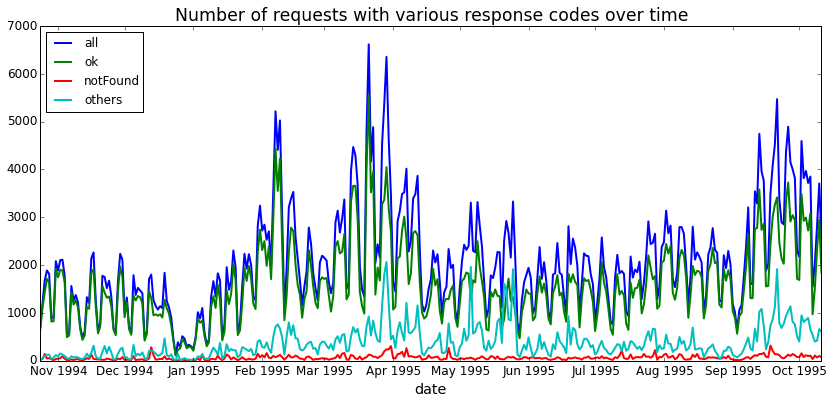

In [20]:
# the actual plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'axes.titlesize': 'xx-large', 'axes.labelsize':'x-large'})
requestsPerDay.plot(figsize=(14,6), linewidth=2, fontsize=12,
                 title = "Number of requests with various response codes over time")

One clearly sees weekly pattern than can be investigated further if needed. Let us have a look at the percentage of "notFound" and "others" over the time

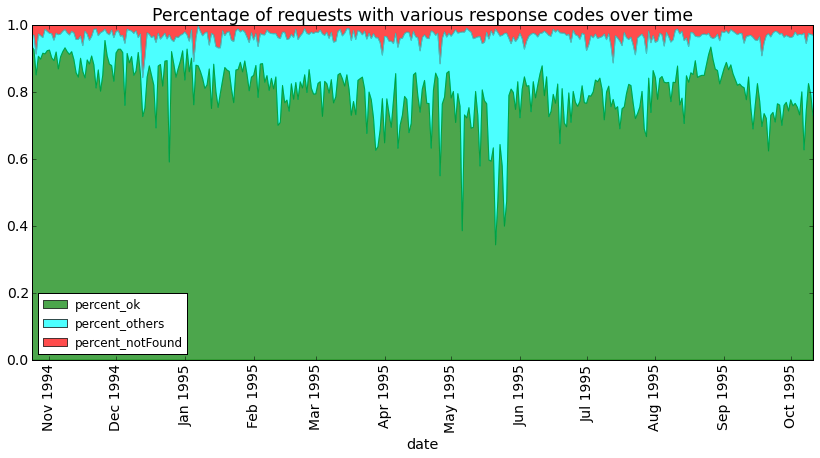

In [21]:
# transforming pandas data frame and plottinh
requestsPerDay['percent_ok'] = requestsPerDay['ok'] / requestsPerDay['all'] 
requestsPerDay['percent_notFound'] = requestsPerDay['notFound'] / requestsPerDay['all'] 
requestsPerDay['percent_others'] = requestsPerDay['others'] / requestsPerDay['all'] 
requestsPerDay[['percent_ok', 'percent_others', 'percent_notFound']].plot(figsize=(14,6), kind='area',
                 fontsize=14, title="Percentage of requests with various response codes over time",
                 color=["green", "cyan", "red"], alpha=0.7, ylim=[0,1], rot=90)

### Hosts, Client IDs, methods, requests, protocols, response codes

In [22]:
# hosts - only 2 hosts here - local and remote
accessLogsRDD.map(lambda log: (log.host, 1)).countByKey()

defaultdict(int, {u'local': 373600, u'remote': 351514})

In [23]:
# client_id is not available
print accessLogsRDD.map(lambda log: log.client_id).distinct().collect()

[u'-']


In [24]:
# user_id is not available - only two users, most are unavailable 
print accessLogsRDD.map(lambda log: log.user_id).countByValue()

defaultdict(<type 'int'>, {u'': 27, u'Villain': 37, u'dasfh': 1, u'-': 725048, u'villain': 1})


In [25]:
# methods - POST, GET, HEAD - predominantly GET
print accessLogsRDD.map(lambda log: log.method).countByValue()

defaultdict(<type 'int'>, {u'POST': 103, u'get': 1, u'HEAD': 597, u'GET': 724413})


In [26]:
# requests - top-10 most frequent
requestsRDD = accessLogsRDD.map(lambda log: (log.request, 1)).reduceByKey(lambda a, b : a + b).cache()
print requestsRDD.keys().count(), "unique requests in data set"
topRequests = requestsRDD.takeOrdered(10, lambda s: -s[1])
print topRequests

12315 unique requests in data set
[(u'index.html', 139681), (u'3.gif', 24006), (u'2.gif', 23595), (u'4.gif', 8018), (u'244.gif', 5148), (u'5.html', 5009), (u'4097.gif', 4874), (u'8870.jpg', 4492), (u'6733.gif', 4278), (u'8472.gif', 3843)]


In [27]:
# protocols
print accessLogsRDD.map(lambda log: log.protocol).countByValue()

defaultdict(<type 'int'>, {u'': 1847, u'1350': 27, u'HTTP': 723240})


In [28]:
# response codes starting from the most frequent - 200, 304, 302, 404, 403
rc = accessLogsRDD.map(lambda log: (log.response_code, 1)).countByKey()
print sorted(rc.iteritems(), key=lambda (k,v): v, reverse=True)

[(200, 568502), (304, 97792), (302, 30325), (404, 23602), (403, 4743), (401, 46), (501, 43), (500, 42), (400, 19)]


### Content size

First of all check that all non-"OK" response codes have zero content_size

In [29]:
print accessLogsRDD.filter(lambda log: log.response_code!=200).map(lambda log: log.content_size).stats()

(count: 156612, mean: 0.0, stdev: 0.0, max: 0.0, min: 0.0)


Are there any record with "OK" code but zero size? Lets have a look at statistics

In [30]:
# content size statistics for response code 200 ("OK")
code200sizeRDD = accessLogsRDD.filter(lambda log: log.response_code==200).map(lambda log: log.content_size).cache()
print "Statistics:", code200sizeRDD.stats()

Statistics: (count: 568502, mean: 13978.0481933, stdev: 112052.55538, max: 11855882.0, min: 0.0)


Since minimum size is 0, there is at least one sich record. Probably the info about the content size was just missing in those records. Recall, that at the beginning we explicityly set 0 for missing values. If needed, this decision can be reconsidered and the corresponding logs analyzed separately. From now on let us concentrate on logs with nonzero size content.

In [31]:
nonzerosizeRDD = code200sizeRDD.filter(lambda size: size > 0).cache()
print "Statistics:", nonzerosizeRDD.stats()

Statistics: (count: 567851, mean: 13994.0730121, stdev: 112115.766958, max: 11855882.0, min: 1.0)


Statistics of the content size hints that the distribution is most likely to be left-skewed and would need log-scale for both "content size" and "counts". Let us have a look at the histogram. This is done _without_ bringing the data to the driver und thus is _not_ restricted by the data size. 

In [32]:
from pprint import pprint
x = range(9)
nonzerosize_histo = nonzerosizeRDD.histogram([10**i for i in x]) #  
print "Histogram:"
pprint(nonzerosize_histo)

Histogram:
([1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000],
 [18, 730, 125189, 321223, 112341, 7618, 722, 10])


This is confirmed by the histogram. Let us plot it.

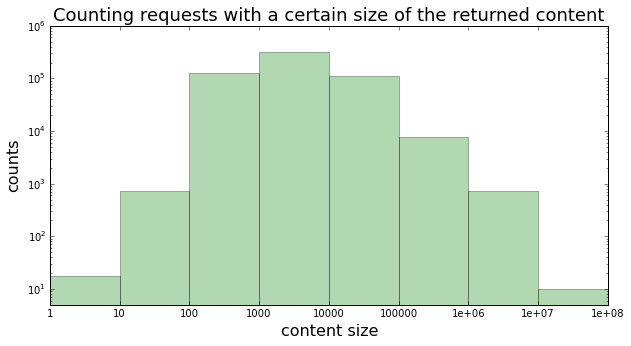

In [33]:
widths = [1]*(len(x)-1)
plt.figure(figsize=(10,5))
plt.axis([1, 8, 5, 1e6])
plt.bar(x[:-1], nonzerosize_histo[1], width=widths, log=True, color="green", alpha=0.3)
plt.xticks(x, map(lambda x: "%g"%x, [10**i for i in x]))
plt.title("Counting requests with a certain size of the returned content", fontsize=18)
plt.xlabel("content size", fontsize=16)
plt.ylabel("counts", fontsize=16)
plt.show()

# 3. Exploring 404 Response Codes
 
Let us explore the 404 response code logs ("Not Found").

In [34]:
code404RecordsRDD = (accessLogsRDD
                 .filter(lambda log: log.response_code==404)
                 .map(lambda log: log.request)
                 .cache())
print 'Found %d bad records (404 response code URLs)' % code404RecordsRDD.count()
print '%d of them are distinct' % code404RecordsRDD.distinct().count()

Found 23602 bad records (404 response code URLs)
3648 of them are distinct


What are the top-10 most frequent not-found requests? 

In [35]:
code404RecordsRDD.map(lambda k: (k,1)).reduceByKey(lambda u,v : u+v).takeOrdered(10, lambda x: -x[1])
# another option would be to use countByValue action and  return the whole dictionary to the driver program
#sorted(code404RecordsRDD.countByValue().iteritems(), key=lambda (k,v): v, reverse=True)[:10]

[(u'index.html', 4704),
 (u'4115.html', 900),
 (u'1611.html', 649),
 (u'5698.xbm', 585),
 (u'710.txt', 408),
 (u'2002.html', 258),
 (u'2177.gif', 193),
 (u'10695.ps', 161),
 (u'6555.html', 153),
 (u'487.gif', 152)]

Having a look at the most frequently non-found request in this list ('index.html'), we recall that it was also requested most frequently. It would be more interesting to know what are the top-10 404-code records as percentage of their requests

In [36]:
percentage404codeRecordsRDD = (accessLogsRDD
                           .map(lambda log: (log.request, log.response_code))
                           .combineByKey(lambda v: (int(v==404), 1),
                                         lambda x,v: (x[0]+int(v==404), x[1]+1),
                                         lambda x,y: (x[0]+y[0], x[1]+y[1]))
                           .mapValues(lambda v: v[0]/float(v[1]) )
                           .cache())
#percentageBadRecordsRDD.take(20)                          
print "These 10 failed at most (actually always):" 
pprint(percentage404codeRecordsRDD.takeOrdered(10, lambda x: -x[1]))
print "These 10 failed at least (actually never):" 
pprint(percentage404codeRecordsRDD.takeOrdered(10, lambda x: x[1]))                          

These 10 failed at most (actually always):
[(u'2198.html', 1.0),
 (u'1292.org/contrib/', 1.0),
 (u'1814.html', 1.0),
 (u'6693.html', 1.0),
 (u'10682.html#ksi_info', 1.0),
 (u'9241.html', 1.0),
 (u'11750.htmI', 1.0),
 (u'4769.gif', 1.0),
 (u'4592.html', 1.0),
 (u'1999.html', 1.0)]
These 10 failed at least (actually never):
[(u'2544.jpg', 0.0),
 (u'3153.html', 0.0),
 (u'2103.html', 0.0),
 (u'8792.map?369,274', 0.0),
 (u'9537.gif', 0.0),
 (u'2345.gif', 0.0),
 (u'2990.html', 0.0),
 (u'10260.gif', 0.0),
 (u'8962.gif"', 0.0),
 (u'8718.html', 0.0)]


Let us make a histogram for the percentage of 404 response codes

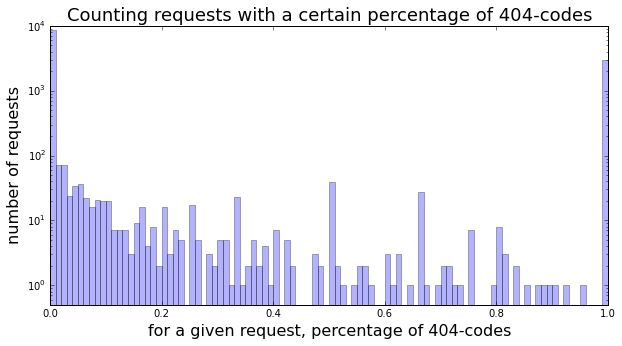

In [37]:
percentage404codeRecordsHist = percentage404codeRecordsRDD.values().histogram(100)
plt.figure(figsize=(10,5))
plt.axis([0, 1, 0.5, 1e4])
plt.bar(percentage404codeRecordsHist[0][:-1], percentage404codeRecordsHist[1], width=0.01, log=True, alpha=0.3)
plt.xlabel("for a given request, percentage of 404-codes", fontsize=16)
plt.ylabel("number of requests", fontsize=16)
plt.title("Counting requests with a certain percentage of 404-codes", fontsize=18)
plt.show()